In [1]:
# System libraries
import time

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

# Custom libraries
import load_mnist as mnist

%matplotlib inline

### Load dataset

In [2]:
training_data, _, testing_data = mnist.read_mnist('data/mnist/', flatten=True)

### Custom Dataset Loader

In [3]:
class ImageDataLoader(Dataset):
    def __init__(self, data):
        self.images = data[0]
        self.labels = data[1]
        self.len = len(self.labels)

    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]

        return image, label
    
    def __len__(self):
        
        return self.len

### Model Definition

In [4]:
class LogisticModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        """Model class constructor"""
        super(LogisticModel, self).__init__()
        self.linear = nn.Linear(input_shape, output_shape)
        
    def forward(self, x):
        
        logits = self.linear(x)
        return logits

### Trainer class

In [17]:
class LogisticRegression:    
    
    def __init__(self, epochs = 50):
        self.frequency = 10
        self.batch_size = 128
        self.epochs = epochs
        self.lr = 0.001
        self.loss_function = self.get_loss_function()
        self.model = LogisticModel(784,10)
        
    def get_data(self, data, batch_size, shuffle=False):
        """Get a data loader
            Args:
                data (pd.DataFrame): dataset
                batch_size (int): batch size
                shuffle (bool): shuffle 
        
            Returns:
                torch.utils.DataLoader: dataset iterator
        """        
        data_iterator = ImageDataLoader(data)
        return DataLoader(data_iterator, batch_size=batch_size, shuffle=shuffle)

    def get_loss_function(self):
        """Define Loss function"""
        return nn.CrossEntropyLoss()
        
    def get_optimizer(self, params):
        """Define gradient descent as the optimizer to minimise the loss"""
        return torch.optim.SGD(params, lr=self.lr)

    def fit(self, data):
        """Train and evaluate model"""
        
        optimizer = self.get_optimizer(self.model.parameters())
        train_dataloader = self.get_data(data, self.batch_size, True)
        print("Training...")
        for epoch in range(1, self.epochs+1):
            
            for batch_idx, (x, y) in enumerate(train_dataloader):
            
                # forward pass
                preds = self.model(x)

                # loss calculation
                loss = self.loss_function(preds, y)

                # backward prop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if epoch % self.frequency == 0:
                loss, accuracy = 0, 0
                with torch.no_grad():
                    for x,y in train_dataloader:
                        preds = self.model(x)
                        loss += self.loss_function(preds, y).item()
                        accuracy += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
                
                print('Epoch {:d} - Train loss: {:.3f} - Train Accuracy: {:.2f}%'.format(
                                    epoch, 
                                    loss/batch_idx,
                                    (accuracy/len(train_dataloader.dataset)) * 100))

    def evaluate(self, data):
        """Evaluate test set"""

        print("Evaluating...")
        # get testing set
        test_dataloader = self.get_data(data, len(data[0]))
        loss, accuracy = 0, 0

        with torch.no_grad():
            for x,y in test_dataloader:
                preds = self.model(x)
                
                loss += self.loss_function(preds, y).item()
                accuracy += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        print('Test loss: {:.3f} - Test Accuracy: {:.2f}%'.format(loss/len(test_dataloader), (accuracy/len(test_dataloader.dataset)) * 100))
            
    def predict(self, data):
        """Prediction"""
        
        print("Predicting...")
        # get testing set
        test_dataloader = self.get_data(data, len(data[0]))
        with torch.no_grad():
            for x, _ in test_dataloader:
                predictions = self.model(x)
                
        return predictions

In [18]:
lr = LogisticRegression()
lr.evaluate(testing_data)
lr.fit(training_data)
lr.evaluate(testing_data)

Evaluating...
Test loss: 2.324 - Test Accuracy: 6.69%
Training...
Epoch 10 - Train loss: 0.854 - Train Accuracy: 83.52%
Epoch 20 - Train loss: 0.645 - Train Accuracy: 85.62%
Epoch 30 - Train loss: 0.561 - Train Accuracy: 86.72%
Epoch 40 - Train loss: 0.513 - Train Accuracy: 87.39%
Epoch 50 - Train loss: 0.481 - Train Accuracy: 87.89%
Evaluating...
Test loss: 0.458 - Test Accuracy: 88.72%


In [20]:
preds = lr.predict(testing_data)
y_preds = preds.argmax(1)

Predicting...


In [13]:
def plot_predictions(x, y):
    '''
    Make a subplot of random test images-predicted label
    '''
    # Plot images with their predicted labels
    plt.figure(figsize=(28,28))
    for idx, image in enumerate(x):
        plt.subplot(len(y),1,1+idx)
        plt.title("Predicted Number: "+ str(y[idx].numpy()))
        fig = plt.imshow(image.reshape(28,28), cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
https://medium.com/@sniafas/regression-with-pytorch

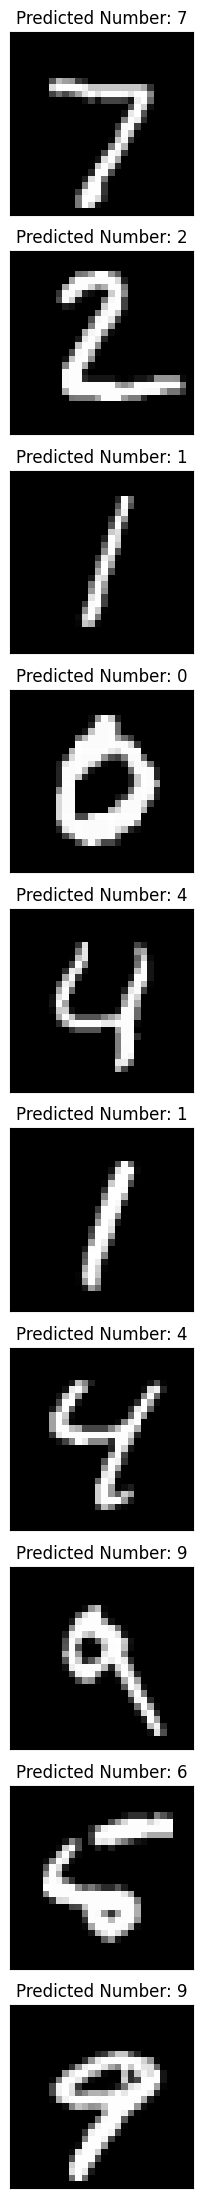

In [22]:
plot_predictions(testing_data[0][:10], y_preds[:10])